# Pastas Project
To create time series models with Pastas, you can use a Pastas Project. A Project is a Python class that contains observations, stresses and models of multiple locations. This class has convenient methods to store time series data, create models, add stressmodels and summarize the results. This notebook is an example of the current possibilities.

In [1]:
# First perform the necessary imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import pastas as ps
%matplotlib inline

In [2]:
## Starting a new Project
pr = ps.Project(name='project for notebook')

## Add observations
We can add oseries to the project. Set kind to 'oseries' to add the series as observations. Observation-series are added to pr.oseries, which is a Pandas DataFrame. The measurement-TimeSeries is in the 'series'-column. Metadata provided to add_series is shown in the other columns of pr.oseries.

In [3]:
# add the observations in all the files in the data-directory that end with _1.csv
datapath = '../data'
files = [x for x in os.listdir(datapath) if x.endswith('_1.csv')]
for file in files:
    fname = os.path.join(datapath,file)
    series = ps.read_dino(fname)
    pr.add_series(series,kind='oseries')
# show the contents of pr.oseries
pr.oseries

INFO: Cannot determine frequency of series B58C0698_1
INFO: Time Series B58C0698_1: 6 nan-value(s) was/were found and filled with: drop


,name,series,kind,x,y,z,projection,Locatie,Filternummer,Externe aanduiding,X-coordinaat,Y-coordinaat,Maaiveld (cm t.o.v. NAP),Datum maaiveld gemeten,Startdatum,Einddatum,Meetpunt (cm t.o.v. NAP),Meetpunt (cm t.o.v. MV),Bovenkant filter (cm t.o.v. NAP),Onderkant filter (cm t.o.v. NAP)
B58C0698_1,B58C0698_1,"TimeSeries(name=B58C0698_1, freq=None, tmin=19...",oseries,181600,359260,26.22,epsg:28992,B58C0698,001,58CP7805,181600,359260,3017,28-10-1985,23-08-2002,28-06-2015,3025,8,2647,2597


## Add stresses
And we can add stresses. To make pr.add_recharge work later, we have to add the precipitation-series as kind='prec' and the evaporation-series as kind='evap'. Stress-series are added to pr.stresses, which is a Pandas DataFrame (just like pr.oseries). The stress-TimeSeries is in the 'series'-column. Metadata provided to add_series is shown in the other columns of pr.stresses.

In [4]:
# add evaporation
fname = os.path.join(datapath,'etmgeg_380.txt')
series = ps.read_knmi(fname, variables='EV24')
pr.add_series(series, kind='evap', settings='evap')

# add precipitation
fname = os.path.join(datapath,'KNMI_Akkrum.txt')
series = ps.read_knmi(fname, variables='RD')
pr.add_series(series, kind='prec', settings='prec')


# show the contents of pr.stresses
pr.stresses

INFO: Inferred frequency from time series EV24 380: freq=D 
INFO: Inferred frequency from time series RD 89: freq=D 


,name,series,kind,x,y,z,projection,description
EV24 380,EV24 380,"TimeSeries(name=EV24 380, freq=None, tmin=1964...",evap,0,0,0,NaN,Referentiegewasverdamping (Makkink) (in m) / P...
RD 89,RD 89,"TimeSeries(name=RD 89, freq=None, tmin=1995-10...",prec,0,0,0,NaN,24-uur som van de neerslag in m van 08.00 voor...


## Make models
We can make models and add recharge. Models are added to pr.models, which is a dictionary with the model-names as the keys, and the models as the values. The add_recharge method finds the closest precipitation- and evaporation-series to the measurement location that the model describes.

The file that we used for precipitation did not contain any coordinates, which will therefore default to 0.0. The evaporation-file contains coordinates in epsg:4326, while our observation-files contain coordinates in epsg:28992. Right now we do not transform coordinates. So finding the closest precipitation- and evaporation-series will normally give wrong results. As we have only one precipitation and evaporation series however, this is not a problem.

In the code-section below, we make three models with recharge and solve them.

In [5]:
for name in pr.oseries.index:
    ml = pr.add_model(name)
    pr.add_recharge(ml)
    ml.solve(report=False)
    
# show the contents of pr.models
pr.models

{'B58C0698_1': Model(oseries=B58C0698_1, name=B58C0698_1, constant=True, noisemodel=True)}

## Plot individual results
Take one of the models and plot the decomposition. As we can see, the precipitation series does not contain the first few years of the simulation. The start- and end-dates of the model (tmin and tmax) are solely determined by the observation-series.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000252E07FC940>,
      dtype=object)

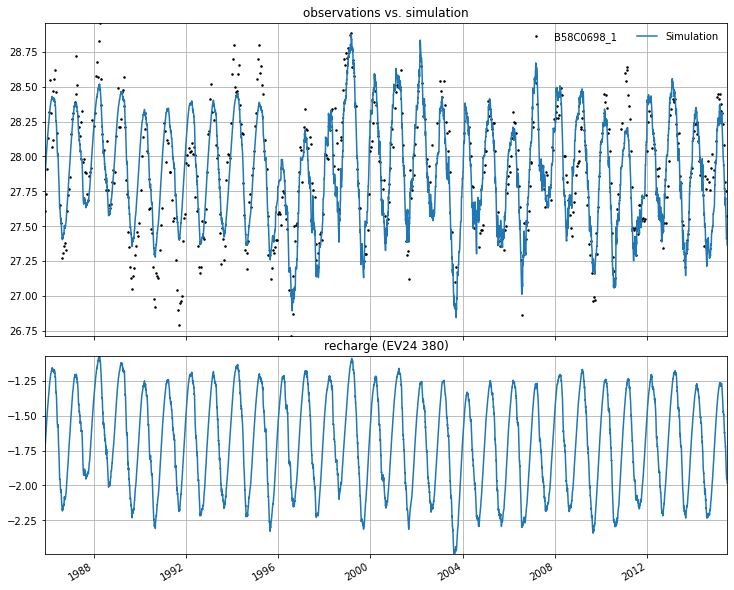

In [6]:
name = 'B58C0698_1'
ml = pr.models[name]
ml.plots.decomposition(split=True)

## Get some statistics / parameters of all models
Make a table with some statistics of the models

In [7]:
pr.get_statistics(['evp','aic'])

evp    77.345314
aic     7.659474
Name: B58C0698_1, dtype: float64

Make a table with some parameters of the models

In [8]:
pr.get_parameters(['recharge_A','constant_d','noise_alpha'])

recharge_A     523.825241
constant_d      28.380347
noise_alpha     83.782557
Name: B58C0698_1, dtype: float64

## Make a map
We can make a map of the locations of oseries. The mapping-functionality of a Pastas Project need to be expanded.

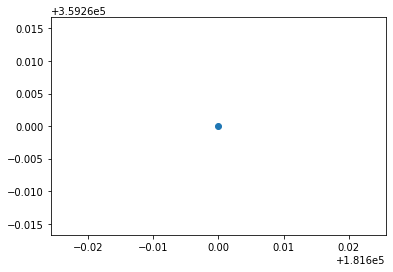

In [9]:
f,ax= plt.subplots()
ax.axis('equal')
pr.maps.series(kind='oseries')

## Saving and loading a project
We can save an entire project, with all its series and models, to a file.

In [10]:
pr.to_file('pastas_project.pas')

pastas_project.pas file succesfully exported


Later we can reload this project again

In [11]:
pr = ps.io.load_project('pastas_project.pas')

INFO: Cannot determine frequency of series B58C0698_1
INFO: Time Series B58C0698_1: 6 nan-value(s) was/were found and filled with: drop
INFO: Pastas Project from file pastas_project.pas succesfully loaded. This file was created with was Pastas0.13.0b. Your current version of Pastas is: 0.13.0b


Test if everything went ok by plotting the decomposition of B58C0698_1 again. This figure is exactly the same as before.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000252E09CE2E8>,
      dtype=object)

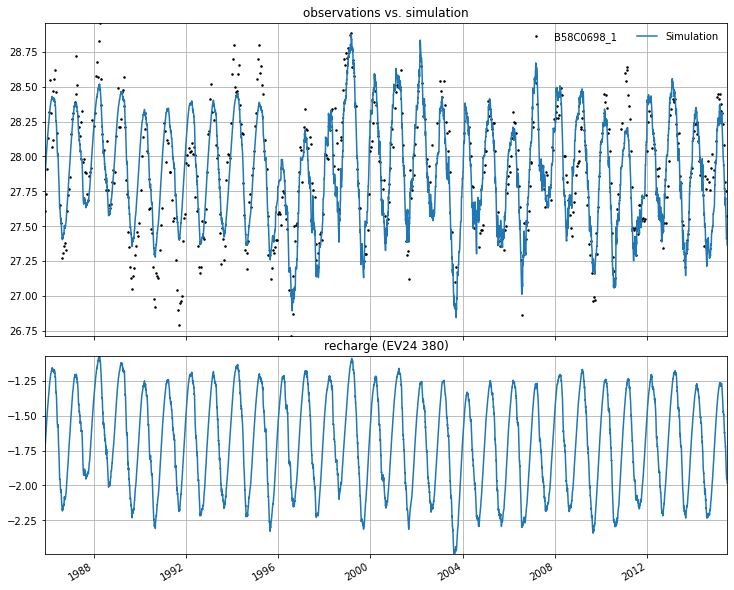

In [12]:
name = 'B58C0698_1'
ml = pr.models[name]
ml.plots.decomposition()